# Lecture 2: Linear Algebra I

Topics:

* A few comments
* Numerical Issues
* Least Squares
* Eigenvalue Decomposition 
* QR Decomposition
* Householder Transformations
* Principal Component Analysis
* Singular Value Decomposition



In [1]:
# Initialize the environment

import sympy as sp
import pandas as pd
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Markdown, display, Math
sp.init_printing(use_latex = True)


In [2]:
# Functions to allow nice display of matrices

sep = '\\; , \\;\\;\\;\\;'
space = '\\;'
def joinMath(*ms):
    sign = '='
    temp_string = sign.join([sp.latex(x) for x in ms])
    final_string = temp_string.replace('[','(').replace(']',')')
    return final_string 

## Dot product

The inner product is a general term which applies to general vector spaces. The dot product is the inner product on a finite Euclidean space.

A special case of inner product:
* the standard inner product: $\mathbf{u \cdot v} = \sum_{k=1}^n u_k^c v_k$  
* the magnitude of a vector $\mathbf b$ is $\vert b \vert = \sqrt{\mathbf b \cdot \mathbf b}$
* the projection of vector $\mathbf a$ to the direction of vector $\mathbf b$ is: $ a_1 = \frac{\mathbf a \cdot \mathbf b}{\vert b \vert} = \vert \mathbf a \vert \cos(\theta) $

<center>
<img src="projection.png" width=300 height=300>
</center>

## Matrix represents linear transformation
Linear function on vectors:
* $L(\mathbf{u + v}) = L(\mathbf u) + L(\mathbf v)$ 
* $L(a\, \mathbf v) = a\, L(\mathbf v)$ 

Any linear transformation between finite dimensional vector space can be represented by a matrix multiplication, therefore we can write $L \mathbf u$ instead of $L(\mathbf u)$.

## When is a correlation matrix not a correlation matrix?

Just because a matrix has ones on the diagonal and the off diagonal elements are in the range of $[ -1 , 1]$ doesn't make the matrix a correlation matrix. All correlation matrices are positive semidefinite. But if the correlation matrix is populated with *estimates*, it is not guaranteed to be positive semidefinite. This can arise when you are using robust estimators or constructing matrices based on pairwise correlations. The issue is that correlations between the various variables are not independent, which means that pairwise correlations cannot be chosen arbitrarily but must satisfy the condition that the determinant of the correlation matrix is greater than or equal to zero. For example, in a $3 \times 3$ matrix, the correlation coefficients must satisfy the equation:

$$
\rho_{12}^2 + \rho_{13}^2 + \rho_{23}^2 - 2 \rho_{12} \rho_{13} \rho_{23} \le 1
$$

For larger matrices, this can be very difficult. One solution is to try to find a [valid correlation matrix that is closest to the estimates](https://academic.oup.com/imajna/article-abstract/22/3/329/708688).

## Implied view of a portfolio

From any portfolio, we can back out its implied excess return forecast $\mathbf f$:
* Assuming the portfolio is mean variance optimal
* It is just the betas to the portfolio
* Only meaningful in a relative sense as well

Consider the market portfolio: the market collectively believe that $\mathbf f \propto \mathbf \beta_m$: 

$$\mathbb{E}[\tilde{\mathbf r}] - r_0 = \mathbf \beta_m \left(r_m - r_0\right)$$

$$r_m = \frac{\mathbb{E}[\mathbf w_m^T \mathbf {\tilde r}]}{\mathbf w_m^T \mathbf 1} $$ is the market portfolio's expected return
* this is exactly the CAPM.

# Numerical Issues

## Storage

As mentioned in Lecture 1, our numerical solutions are generally I/O constrained rather than processor constrained. While this is most obvious if the routine has a large number of read/write operations, it is also affected by how data is stored in memory. All numerical libraries store the data of a generic (dense) matrix in a *linear* array of length $m \times n$ (or longer). Depending on the language, this is either *row* major or *column* major.

For a matrix $A$

$$
A=
\begin{pmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{pmatrix}
$$

$$
\text{Row Major} =
\begin{bmatrix}
1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9
\end{bmatrix}
^T
$$

$$
\text{Column Major} =
\begin{bmatrix}
1 & 4 & 7 & 2 & 5 & 8 & 3 & 6 & 9
\end{bmatrix}
^T
$$

<center> <img src="column-row.png" width=500 height=300> </center>

* `Python`, C-arrays and bitmaps are row major.
* Fortran, Matlab, Eigen are column major.

But you can force `Python` to be either:

In [3]:
 # array creation
A = np.array([[1, 2], [3, 4]]) # default (row major) storage
B = np.array([[1, 2], [3, 4]], order='F') # column major storage

# show internal storage
np.ravel(A, 'K') # array elements as stored in memory: [1, 2, 3, 4]
np.ravel(B, 'K') # array elements as stored in memory: [1, 3, 2, 4]

# nothing happens to the data on transpose, just the storage order changes
np.ravel(A.T, 'K') # array elements as stored in memory: [1, 2, 3, 4]
np.ravel(B.T, 'K') # array elements as stored in memory: [1, 3, 2 ,4]

# storage order can be accessed by checking the array’s flags
print(f"A: {A.flags['C_CONTIGUOUS']} row major") # True
print(f"B: {B.flags['F_CONTIGUOUS']} column major") # True
print( )
print(f"A transpose: {A.T.flags['F_CONTIGUOUS']} column major") # True
print(f"B transpose: {B.T.flags['C_CONTIGUOUS']} row major") # True

A: True row major
B: True column major

A transpose: True column major
B transpose: True row major


This "layout" of a matrix affects the time that calculations take, consider the example from [Hilpisch](https://www.amazon.com/Python-Finance-Analyze-Financial-Data/dp/1491945281):

In [4]:
import numpy as np
x = np.random.standard_normal((3, 150000)) # 3 by 150,000
C = np.array(x, order='C') # put in row major
F = np.array(x, order='F') # put in column major
x = 0.0

In [5]:
%timeit C.sum(axis=0) # sum columns: row major

390 µs ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
%timeit F.sum(axis=0) # sum columns: column major

1.56 ms ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%timeit C.sum(axis=1) # sum rows: row major

134 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
%timeit F.sum(axis=1) # sum rows: column major

2.31 ms ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%timeit C.std(axis=0) # std columns: row major

2.15 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit F.std(axis=0) # std columns: column major

5.63 ms ± 80 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%timeit C.std(axis=1) # std rows: row major

1.38 ms ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%timeit F.std(axis=1) # std rows: column major

6.29 ms ± 66.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
C = 0; F = 0

**Question**: Why did we set C and F to zero?

### Computational Effort

The computational effort required by numerical code refers to the number of elementary operations (addition, subtraction, multiplication, division, and square root) executed in a run.

It used to be that this mattered, but today this is no longer really an issue. Computational effort is only loosely related to overall execution time on modern computers. I/O complexity might be more appropriate since it takes into account the pattern of memory access.

#### Asymptotic Complexity

Computational effort is still useful in the context of asymptotic complexity, which is defined as the *worst-case* dependence of the computational effort on one or more problem size parameters as they tend to infinity.

Asymptotic complexity of a numerical algorithm is stated as an order of magnitude, often in big-O notation:

* binary search: $O(\log(n))$
* best sorting algorithm: $O(n \log(n))$

Most common numerical linear algebra algorithms are of complexity of $O(n^3)$
* matrix multiplication: $n^2$ elements in output, each element takes $O(n)$
* LU decomposition: $n$ diagonal elements, to zero-out each column costs $O(n^2)$
* Cholesky decomposition: $n$ recursive steps, each takes $O(n^2)$

Asymptotic complexity allows to predict the dependence of the runtime of a
particular implementation of an algorithm on the problem size (for large problems).

It is, at times, possible to reduce complexity in numerical linear algebra by performing operations in a particular order. Consider two approaches of rank-1 matrices:

$$
y = ( a b^T ) x
\hspace{1 in}
y =  a (b^T  x)
$$

The first has complexity $O(mn)$, while the second has complexity $O(n+m)$ or linear complexity. To see why, the first is:

$$
\left[
\begin{pmatrix}
a_1\\
\vdots \\
a_m
\end{pmatrix}
\begin{pmatrix}
b_1 & \cdots b_n
\end{pmatrix}
\right]
\begin{pmatrix}
x_1\\
\vdots \\
x_n
\end{pmatrix}
=
\begin{pmatrix}
a_1 b_1 & \cdots & a_1 b_n\\
\vdots & \vdots & \vdots \\
a_m & \cdots & a_m b_n
\end{pmatrix}
\begin{pmatrix}
x_1\\
\vdots \\
x_n
\end{pmatrix}
$$

and the second is:

$$
\begin{pmatrix}
a_1\\
\vdots \\
a_m
\end{pmatrix}
\left[
\begin{pmatrix}
b_1 & \cdots b_n
\end{pmatrix}
\begin{pmatrix}
x_1\\
\vdots \\
x_n
\end{pmatrix}
\right]
=
\begin{pmatrix}
a_1\\
\vdots \\
a_m
\end{pmatrix}
\begin{pmatrix}
\text{a number}
\end{pmatrix}
$$

# Least Squares


## Least square problem

Given an unknown scalar function $\mathbf{y} = y(\mathbf{x})$, where the argument $\mathbf x$ is an $n$ dimensional vector.

* We have $m > n$ observations: $X$ represents inputs and $\mathbf y$ represents outputs:

 $$
 \small X  = 
 \begin{pmatrix}
 \mathbf x_1^T \\ 
 \mathbf x _2^T \\
 \vdots \\
 \mathbf x _m^T
 \end{pmatrix}
 ,\: \;\; 
 \mathbf{y} =
 \begin{pmatrix}y_1 \\ y_2 \\ \vdots \\ y_m
 \end{pmatrix}$$
 

* We want to find a factor loading vector $\mathbf{\hat\beta}$ so that the linear function $\hat y = \mathbf X \mathbf{\hat{\beta}}$ best approximates the observed inputs/outputs.
* $X \mathbf \beta = \mathbf y$ is over-determined, so no vector $\mathbf \beta$ solves it exactly
* Instead, we find the $\mathbf \beta^* $ that minimizes $\Vert X \mathbf{\beta - y}\Vert_2$.

## Pseudo-inverse:

$$ \mathbf \beta^* = \text{argmin}_{\mathbf {\beta}} \Vert X \mathbf{\beta - y} \Vert_2$$
Which can be easily solved using matrix calculus when the columns of $X$ are independent (which makes $X^TX$ invertible):

$$
\begin{array}{cc}
\begin{aligned}
\Vert X \mathbf{\beta - y} \Vert_2^2 &= (X \mathbf{\beta - y})^T (X \mathbf{\beta - y}) \\
 &= \mathbf{\beta}^T X^T X \mathbf{\beta} - 2 \mathbf{\beta}^TX^T\mathbf y + \mathbf y^T\mathbf y\\[5pt]
\frac{\partial}{\partial \mathbf \beta^T} \Vert X \mathbf{\beta - y} \Vert_2^2 &= 2 X^TX \mathbf \beta  - 2X^T \mathbf y  = \mathbf 0 \\[5pt]
\mathbf \beta^* &= (X^TX)^{-1}X^T\mathbf y
\end{aligned}
\end{array}
$$

The left pseudo-inverse is given by $X^+ = (X^TX)^{-1}X^T$ since $X^+X = I$.

* The solution is equivalent to ordinary linear regression, but the later requires stronger assumptions for forecasting:
    * Linear relationship
    * Residuals are normally distributed
    * Independence
    * Homoscedasticity


If the rows of $X$ are linearly independent so $XX^T$ is invertible and 
$X^* = X^T(XX^T)^{-1}$ is also known as the right pseudo-inverse of $X$ because $XX^* = I$.

If both the columns and the rows of the matrix are linearly independent, then the matrix is invertible and the pseudo-inverse is equal to the inverse of the matrix.

**Note**: In practice,the inverse of $XX^T$ is never computed. It appears in the formula but not in the computation.

The pseudo-inverse is the "closest" answer to $X^+X = I$ in the sense that the norm $\Vert X^+X - I \Vert_2$ is the smallest. When the inverse exists, it is zero.

Consider the linear system $A \mathbf x = \mathbf b$. As discussed in the Linear Algebra Review, this system has 0, 1, or infinitely many solutions. $\mathbf x = A^+ \mathbf b$ is the closest solution when none exists. It gives the single answer when one exists, and, when many exist, it is the smallest solution in the sense that $\Vert \mathbf{x} \Vert_2$ is smallest.

### Using the pseudo-inverse to solve an overdetermined system of equations

Consider this [example](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.9-The-Moore-Penrose-Pseudoinverse/) with three equations and two unknowns.

$$
\begin{array}{cc}
-2x_1 -x_2 = -2 \\
4x_1 - x_2 = -8 \\
-x_1 - x_2 = -2
\end{array}
$$

Plotting the system:

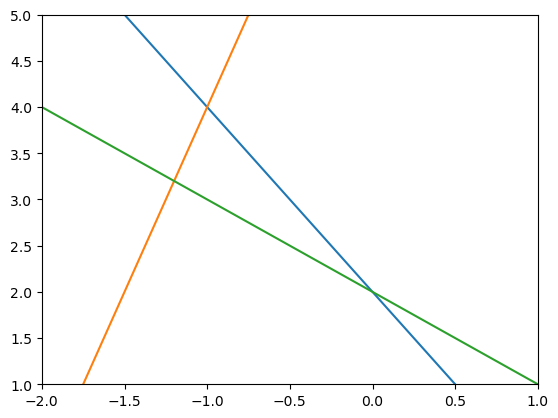

In [14]:
x1 = np.linspace(-5, 5, 1000)
x2_1 = -2*x1 + 2
x2_2 = 4*x1 + 8
x2_3 = -1*x1 + 2

plt.plot(x1, x2_1)
plt.plot(x1, x2_2)
plt.plot(x1, x2_3)
plt.xlim(-2., 1)
plt.ylim(1, 5);
#plt.show()

We can see that there is no solution.

**Question**: How?

We can put this in matrix form:

$$
\begin{pmatrix}
-2 & -1 \\
4 & -1 \\
-1 & -1 
\end{pmatrix}
\begin{pmatrix}
x_1 \\
x_2
\end{pmatrix}
=
\begin{pmatrix}
-2 \\
-8 \\
-2
\end{pmatrix}
$$

Calculating the pseudo-inverse of $A$:

In [15]:
A = np.array([[-2, -1], [4, -1], [-1, -1]])
A_plus = np.linalg.pinv(A)
A_plus

array([[-0.11290323,  0.17741935, -0.06451613],
       [-0.37096774, -0.27419355, -0.35483871]])

With the pseudo-inverse, we can find $\mathbf x$ using $A^+ \mathbf b = \mathbf x$

In [16]:
b = np.array([[-2], [-8], [-2]])
res = A_plus @ b
res

array([[-1.06451613],
       [ 3.64516129]])

Plotting this point along with the equation lines:

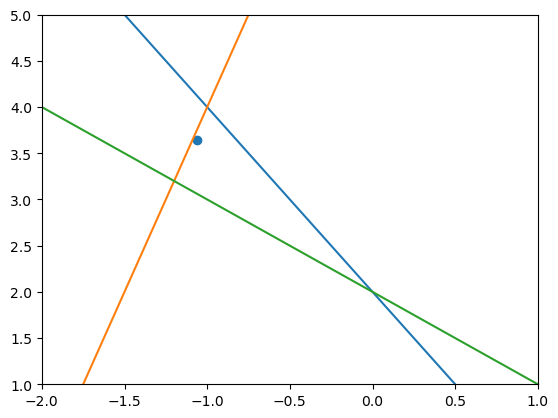

In [17]:
plt.plot(x1, x2_1)
plt.plot(x1, x2_2)
plt.plot(x1, x2_3)
plt.xlim(-2., 1)
plt.ylim(1, 5)

plt.scatter(res[0], res[1]);



This is actually **not** the correct answer.

**Question**: Why?

Rescaling the second equation and executing the same steps...

In [18]:
A = np.array([[-2, -1], [1, -0.25], [-1, -1]])
A_plus = np.linalg.pinv(A)
A_plus

array([[-0.28571429,  0.57142857,  0.14285714],
       [-0.1038961 , -0.88311688, -0.67532468]])

In [19]:
b = np.array([[-2], [-2], [-2]])
res = A_plus @ b 
res

array([[-0.85714286],
       [ 3.32467532]])

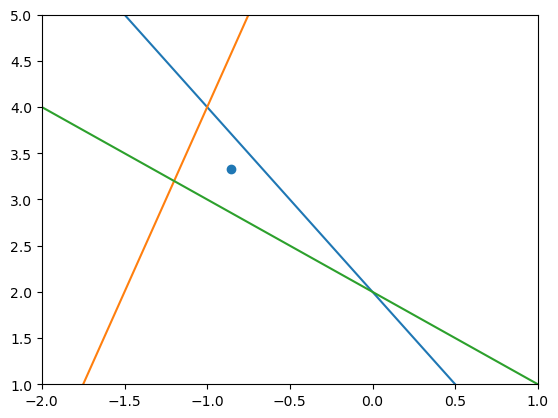

In [20]:
plt.plot(x1, x2_1)
plt.plot(x1, x2_2)
plt.plot(x1, x2_3)
plt.xlim(-2., 1)
plt.ylim(1, 5)

plt.scatter(res[0], res[1])

plt.show()

Much better, now the solution lies (approximately) at the barycenter of the triangle!

## Ridge regression

The $\mathbf \beta$ that solves the least square problem will usually suffer when there are a large number of variables due to multicollinearity (*e.g.* the more variables used, the more likely they are correlated with each other).

Ridge regression adds a penalty to the objective function of the least square problem: 

$$
\begin{array}{cc}
\begin{aligned}
\mathcal L(\mathbf \beta) &= \Vert X \mathbf{\beta - y} \Vert_2^2 + \lambda \Vert W \mathbf \beta \Vert_2^2 \\[2pt]
&=  \mathbf{\beta}^T X^T X \mathbf{\beta} - 2 \mathbf{\beta}^TX^T\mathbf y + \mathbf y^T \mathbf y + \lambda \mathbf \beta^T W^TW \mathbf \beta \\
\\
\frac{\partial \mathcal L}{\partial \mathbf \beta^T} &= 2X^TX \mathbf \beta   - 2X^T \mathbf y + 2 \lambda W^T W \mathbf \beta = \mathbf 0 \\[5pt]
\mathbf \beta &= (X^TX + \lambda W^TW)^{-1}X^T\mathbf y
\end{aligned}
\end{array}
$$





It can be shown that this estimator is the solution to the least squares problem subject to the constraint $\mathbf{\beta^T} \mathbf{\beta} = \mathbf{c}$ which can be expressed as a Lagrangian:

$$
\mathcal L = \min_{\mathbf{\beta}} (\mathbf{y} - X \mathbf{\beta}\,)^T (\mathbf{y} - X \mathbf{\beta}\,) + \lambda (\mathbf{\beta^T} \mathbf{\beta} - \mathbf{c})$$

which shows that $\lambda$ is the Lagrange multiplier of the constraint. When $\lambda = 0$ the constraint is non-binding and the ridge estimator reduces to the least squares estimator.

* $W$ is a diagonal weighting matrix for the elements in $\mathbf \beta$, e.g. $W = I$ is often a good start
* $\lambda$ is a scalar penalty rate
* Ridge regression is a special case of [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization).
* Ridge regression is more robust, it works even if $X$ is not of full rank 
* Often used for constructing hedging portfolios

### Ridge regression example

We draw many pairs of $x, y, z$ from the following linear model: 

$$  y = 2x + 0.0001z + 5 + \epsilon $$

* $x, z$ are standard normal, $z$ represents an insignificant feature (or accidental correlation)
* $\epsilon$ is a standard normal noise

We regress the vector $\mathbf y$ against $X = [\mathbf x, \mathbf x + .0001 \mathbf z, \mathbf 1] = [\mathbf x , \mathbf z^*, \mathbf 1]$:

In [27]:
import pandas as pd

n = 5000
x = np.random.normal(size=n)
z = np.random.normal(size=n)
y = 2*x + 5 + 0.0001*z + np.random.normal(size=n)

X = np.array([x, x + 0.0001*z, np.ones(len(x))]).T

W = np.eye(len(X.T))
lbd = 0.1 # lambda
beta_ols = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
error_ols = np.linalg.norm(y - X.dot(beta_ols), 2)

beta_ridge = np.linalg.inv(X.T.dot(X) + lbd*W.T.dot(W)).dot(X.T).dot(y)
error_ridge = np.linalg.norm(y - X.dot(beta_ridge), 2)



df = pd.DataFrame(np.array([beta_ols, beta_ridge]), index=['Least square', 'Ridge regression lambda=%2g' % lbd], 
                  columns=['x','z*', '1'])


display(df)


,x,z*,1
Least square,104.653294,-102.665449,4.979857
Ridge regression lambda=0.1,1.020297,0.967514,4.979712


### Regularization

In ridge regression, you can tune the lambda parameter so that model coefficients change, this is an example of *regularization*. 

**Note**: There is no equation for finding the the best lambda. If ridge regression is being used for prediction, you iterate over lambda in your training set to find the value that minimizes the mean-squared-error.

Two other popular regularizations are:

* LASSO regression: resulting in sparse $\mathbf \beta$

$$
\mathcal L(\mathbf \beta) = \Vert X \mathbf{\beta - y} \Vert_2^2 + \lambda \Vert W \mathbf \beta \Vert_1
$$

* Elastic-Net: in between LASSO and Ridge

$$
\mathcal L(\mathbf \beta) = \Vert X \mathbf{\beta - y} \Vert_2^2 + \lambda_1 \Vert W \mathbf \beta \Vert_1 + \lambda_2 \Vert W \mathbf \beta \Vert_2^2
$$

Both LASSO and Elastic-Net are equivalent to [support vector machines (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine).

## Condition number of non-square matrix

In the Linear Algebra Review, we already proved that the condition number for an invertible matrix $A$ is: 

$$k(A) = \Vert A \Vert \Vert A^{-1} \Vert$$

Following the same proof, we can extend this to non-square matrix using pseudo-inverse:

$$k(A) = \Vert A \Vert \Vert A^{+} \Vert$$


# QR Decomposition




The QR algorithm was developed in the late 1950s by [John G. F. Francis](https://en.wikipedia.org/wiki/John_G._F._Francis) and by [Vera N. Kublanovskaya](https://en.wikipedia.org/wiki/Vera_Kublanovskaya), working independently. The QR algorithm was chosen as one of the most important numerical methods of the [20th century](https://archive.siam.org/pdf/news/637.pdf).

Any real matrix $A$ can be decomposed into $A = QR$:
* $Q$ is orthogonal ($QQ^T = I$)
* $R$ is upper triangular, with the same dimension as $A$

QR decomposition is numerically stable but slower to execute. This algorithm is unconditionally stable because only orthogonal transformations are used.



$$
\overbrace{
\begin{pmatrix}
 \times & \times & \times & \times \\  
 \times & \times & \times & \times \\ 
 \times & \times & \times & \times \\ 
 \times & \times & \times & \times \\ 
\times & \times & \times & \times \\ 
\times & \times & \times & \times 
\end{pmatrix}
}^A
=
\overbrace{\begin{pmatrix}
\times & \times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times & \times
\end{pmatrix}
}^Q
\;\;
\overbrace{\begin{pmatrix}
\times & \times & \times & \times \\ 
0 & \times & \times & \times \\ 
0 & 0 & \times & \times \\
0 & 0 & 0 & \times \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
}^R
$$


If $A$ is not fully ranked:
* $Q$ remains full rank (as are all orthogonal matrices)
* $R$ has more 0 rows 

To be clear, what we are doing with this "decomposition" is taking any real matrix $A$ and transforming it through a series of steps into a orthogonal matrix $Q$ times an upper triangular matrix $R$. There are several ways to do a $QR$ decomposition as noted in the Linear Algebra Review. We will focus on the transformation that is numerically more accurate, the [Householder](https://en.wikipedia.org/wiki/Alston_Scott_Householder) transformation.

## Householder transformation

In Gaussian elimination, we conducted a series of transformations that introduced zeros into the lower triangle of a matrix. Householder transformations are orthogonal transformations (reflections) that can be used to similar effect, that is, to introduce zeros below the diagonal of the matrix. Reflection across the subspace of vectors orthogonal to a unit normal vector $\mathbf u$ can be expressed in matrix form as:

$$
H = I - 2 \mathbf{u} \mathbf{u}^H 
$$

An orthogonal transformation representing reflection over a hyper plane, with a normal vector $\mathbf{u}$ with unit L-2 norm:

$$ H \mathbf x = (I - {2\mathbf{u u}^H}) \mathbf x = \mathbf x - 2 \mathbf{u} (\mathbf {u}^H \mathbf x)  $$


<center><img src = "reflector.png" height=300 width=500></center>

Household transformation can reflect an arbitrary vector $\mathbf v$ to $ \Vert \mathbf v \Vert_2 \mathbf{u}$, where $\mathbf{u}$ can be any unit vector. 

Geometrically, a Householder matrix takes every vector into its mirror image on the other side of a plane that is perpendicular to $\mathbf u$.


<center><img src = "reflector2.png" height=300 width=500></center>


It is obvious that the vector $\mathbf{u}$ that is perpendicular to the space of reflection must be in the direction of $\mathbf v = \mathbf x - \mathbf y $.

The matrix $H$ is symmetric. It is also orthogonal because:

$$
H^H H = (I - 2 \mathbf{u u}^H)(I - 2 \mathbf{u u}^H) = I - 4 \mathbf{u u}^H + 4 \mathbf{u u}^H \mathbf{u u}^H = I
$$

For example, given a normal vector $\mathbf{u}$, we can find $H$:

$$
\mathbf{u} =
\begin{pmatrix}
1\\
0
\end{pmatrix}
\hspace{0.5 in}
H = I - 2\mathbf{u u}^T =
\begin{pmatrix}
-1 & 0 \\
0 & 1
\end{pmatrix}
$$


Recognizing that the product of unitary matrices is also unitary, for any $A \in \mathbb{C}^{m \times n}$, it is possible to find a sequence of unitary matrices, $\{ H_0, H_1, \dots, H_{n-1} \}$ such that $H_{n-1} \cdots H_0 A = R$, where $R \in \mathbb{C}^{n \times n}$ is upper triangular. Then:

$$
A = \underbrace{H_0^H \cdots H_{n-1}^H}_Q R
$$

This is stable numerically because the unitary matrices preserve the norms (or lengths) of each of the column vectors in $A$, which precludes the subtraction required in either Gram-Schmidt or modified Gram-Schmidt, which can lead to catastrophic cancellation.

<center><img src = "cancellation.png" height=300 width=500></center>

The $QR$ decomposition using Householder transformations is an iterative process sequentially applied to the column vectors of $A$.

$$
A
=
\begin{pmatrix}
| & | & \cdots & | \\
\mathbf a_1 & \mathbf a_2 & \cdots & \mathbf{a}_n\\
| & | & \cdots & |
\end{pmatrix}
= 
\begin{pmatrix}
 \times & \times & \times & \times \\  
 \times & \times & \times & \times \\ 
 \times & \times & \times & \times \\ 
 \times & \times & \times & \times \\ 
\times & \times & \times & \times \\ 
\times & \times & \times & \times 
\end{pmatrix}
$$

And apply the first Householder transformation such that:

$$
H_1 A= 
\begin{pmatrix}
 \times & \times & \times & \times \\  
 0 & \times & \times & \times \\ 
 0 & \times & \times & \times \\ 
 0 & \times & \times & \times \\ 
0 & \times & \times & \times \\ 
0 & \times & \times & \times 
\end{pmatrix}
$$

The second Householder transformation such that:

$$
H_2 H_1 A= 
\begin{pmatrix}
 \times & \times & \times & \times \\  
 0 & \times & \times & \times \\ 
 0 & 0 & \times & \times \\ 
 0 & 0 & \times & \times \\ 
0 & 0 & \times & \times \\ 
0 & 0 & \times & \times 
\end{pmatrix}
$$

Continuing until the end is reached and we have transformed $A$ into an upper triangular matrix by multiplying a sequence of unitary matrices.

$$
H_4 \cdots H_2 H_1 A= 
\begin{pmatrix}
 \times & \times & \times & \times \\  
 0 & \times & \times & \times \\ 
 0 & 0 & \times & \times \\ 
 0 & 0 & 0 & \times \\ 
0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 
\end{pmatrix}
$$

### QR decomposition using Householder

We show how to use Householder transformation to perform QR decomposition of the matrix 

$$
A =
\begin{pmatrix}
5.0 & 4.0 & -3.0 & 2.0 \\
4.0 & 4.0 & 2.0 & -1.0 \\
-3.0 & 2.0 & 3.0 & 0.0 \\
2.0 & -1.0 & 0.0 & -2.0 
\end{pmatrix}
$$ 

In [28]:
def qr_next(a) :
    q, r = np.linalg.qr(a)
    return r.dot(q)

a = np.array([[5, 4, -3, 2], [4, 4, 2, -1], [-3, 2, 3, 0], [2, -1, 0, -2]])
A = sp.MatrixSymbol('A', 4, 4)
A1 = sp.MatrixSymbol('A_1', 4, 4)
Q = sp.MatrixSymbol('Q_0', 4, 4)
R = sp.MatrixSymbol('R_0', 4, 4)

display(Math(space))
display(Math(joinMath(A, sp.Matrix(a))))
display(Math(space))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The first step, zero out the lower triangle of the first column by a Householder transformation

In [29]:
def householder(x0, e=0) :
    n = len(x0)
    e1 = np.zeros(n-e)
    x = x0[e:]
    e1[0] = np.linalg.norm(x, 2)
    u = x - e1
    v = np.matrix(u/np.linalg.norm(u, 2))
    hs = np.eye(n-e) - 2*v.T*v
    h = np.eye(n)
    h[e:,e:] = hs
    return h

x, u, e1, Q, R = sp.symbols("x, u, e_1, Q, R")
xn = sp.symbols("\Vert{x}\Vert_2")
b = a[:, 0]
c = np.zeros(len(b))
c[0] = np.linalg.norm(b, 2)

display(Math(space))
display(Math(joinMath(A, sp.Matrix(np.round(a))) + sep +
             joinMath(x, sp.Matrix(a[:,0]))))

display(Math(space))

display(Math(joinMath(xn, np.round(np.linalg.norm(b, 2), 3)) + sep +
                joinMath(e1, sp.Matrix([1, 0, 0, 0])) + sep +
                joinMath(u, sp.Matrix(a[:,0]-c).evalf(3))))

display(Math(space))

    
h1 = householder(a[:, 0], 0)
H1 = sp.MatrixSymbol('H_1', 4, 4)
a1 = h1.dot(a)
display(Math(joinMath(H1, sp.Matrix(np.round(h1, 3))) + sep + 
                joinMath(H1*A, sp.Matrix(np.round(a1, 3)))))
display(Math(space))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

continue to zero out the lower triangle

In [30]:
h2 = householder(a1[:, 1], 1)
H2 = sp.MatrixSymbol('H_2', 4, 4)
a2 = h2.dot(a1)
display(Math(space))
display(Math(joinMath(H2, sp.Matrix(np.round(h2, 3))) + sep +
                joinMath(H2*H1*A, sp.Matrix(np.round(a2, 3)))))
display(Math(space))

h3 = householder(a2[:, 2], 2)
H3 = sp.MatrixSymbol('H_3', 4, 4)
a3 = h3.dot(a2)
display(Math(space))
display(Math(joinMath(H3, sp.Matrix(np.round(h3, 3))) + sep +
                joinMath(H3*H2*H1*A, sp.Matrix(np.round(a3, 3)))))
display(Math(space))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

the final results are therefore $Q = (H_3H_2H_1)^T$ and $R = Q^T A$:

In [31]:
q = (h3.dot(h2).dot(h1)).T
r = q.T.dot(a)
np.round(q.dot(r), 4)

Q = sp.MatrixSymbol('Q', 4, 4)
R = sp.MatrixSymbol('R', 4, 4)
display(Math(space))
display(Math(joinMath(Q, sp.Matrix(np.round(q, 3))) + sep +
             joinMath(R, sp.Matrix(np.round(r, 3)))))
display(Math(space))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## QR decomposition for least square problem

$$ \min_{\mathbf {\beta}} \Vert X \mathbf{\beta - y} \Vert_2$$

given the QR decomposition of $X = QR$:

$$ 
\min_{\mathbf {\beta}} \Vert X \mathbf{\beta - y} \Vert_2 
= 
\min_{\mathbf {\beta}} \Vert Q^T X \mathbf \beta - Q^T \mathbf y \Vert_2 
= 
\min_{\mathbf {\beta}} \Vert R \mathbf \beta - \mathbf y'\Vert_2
$$

note that $R$ is right triangular, the vector whose norm is to be minimized looks like:

$$\scriptsize \begin{pmatrix}
r_{11} & r_{12} & \cdots & r_{1n} \\
0 & r_{22} & \cdots & r_{2n} \\
\vdots & \ddots & \ddots & \vdots \\
0  & \cdots\ & 0 & r_{nn} \\
\hline
0 & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & 0 
\end{pmatrix} 
\begin{pmatrix}
\beta_1 \\ \beta_2 \\ \vdots \\ \beta_n
\end{pmatrix} -
\begin{pmatrix}
y'_1 \\ y'_2 \\ \vdots \\ y'_n \\ \hline y'_{n+1} \\ \vdots \\ y'_m
\end{pmatrix}
$$



# Eigenvalue Decomposition (EVD)

Also known as spectral decomposition, The term *spectrum* refers to the eigenvalues of a matrix or, more generally, a linear operator and is motivated by physics. The spectral energy lines of atoms, molecules and nuclei are characterized as the eigenvalues of the governing quantum mechanical Schrodinger operator.

* eigen means characteristic



## Definitions

For a square matrix $A$ of size $n \times n$, if there exists a vector $\mathbf {v \ne 0}$ and a scalar $\lambda $ so that:

$$ A \mathbf v = \lambda \mathbf v $$

* $\mathbf v$ is an eigenvector,  $\lambda$ is the corresponding eigenvalue
* $A$ only changes $\mathbf v$'s magnitude, but not direction
* $\lambda$ can be complex even for real $A$
* there can be at most $n$ distinct eigenvalues
* eigenvalues can be negative or complex
* $\prod_{i}\lambda_i = \det( A )$
* $\sum_i\lambda_i = \text{tr}(A)$

### Characteristic equation

Rewriting the equation as:

$$ (A - \lambda I) \mathbf {v = 0}$$

It has non-zero solution if and only if:

$$ p\,(\lambda) = \det(A - \lambda I) = 0$$ 

where $p\,(\lambda)$ is a polynomial of degree $n$.



Consider, for example, the matrix

$$
\begin{pmatrix}
-2 & -4 & 2 \\
-2 & 1 & 2 \\
4 & 5 & 5
\end{pmatrix}
$$

The characteristic equation is 
$$
\det
\begin{pmatrix}
-2-\lambda & -4 & 2 \\
-2 & 1-\lambda & 2 \\
4 & 5 & 5 - \lambda
\end{pmatrix}
=0
$$

Expanding the determinant
$$
(-2-\lambda)[(1-\lambda)(5-\lambda)-(2 \times 2)] + 4[(-2) \times (5-\lambda) -(4 \times 2)] + 2[(-2 \times 2) - 4 (1-\lambda)]=0
$$

simplifying
$$ \lambda^3 - 4 \lambda^2 -27 \lambda +90 = 0$$

which can be factored
$$ (\lambda -3)(\lambda^2 - \lambda - 30) =(\lambda -3)(\lambda + 5)(\lambda-6)$$

Which gives us the eigenvalues 3,-5, and 6.

Clearly, solving the polynomial for higher degrees would be quite complicated.

It is difficult to solve the characteristic function for $\lambda_i$, especially for large $n$.
* But once we have eigenvalues, it is easy to find corresponding eigenvectors.

### Properties of eigenvectors

Eigenvectors are usually specified as unit L2 vectors of $\Vert \mathbf v \Vert_2^2 = \mathbf v^T \mathbf v = 1$. 
* $\mathbf v$ and $- \mathbf v$ are equivalent unit eigenvectors
  
* Eigenvectors of distinct eigenvalues are linearly independent.



If $A$ is full rank and has distinct eigenvalues, then all the eigenvectors form a basis for the vector space and we can write:

$$ A R = R \Lambda$$

where each column of $R$ is an eigenvector, and $\Lambda$ is a diagonal matrix of eigenvalues


$R$ is invertible because eigenvectors are all independent:

$$\begin{array}{cc}
R^{-1} A = \Lambda R^{-1} \\[5pt]
 A^H(R^{-1})^H = (R^{-1})^H \Lambda^H
\end{array}$$

$A$ is real and symmetric if: $A^H = A$:

If $A = A^T$ is a real symmetric $n \times n$ matrix (as in the case of covariance or correlation matrices)

* $\Lambda^H = \Lambda$, therefore all eigenvalues are real
* Eigenvectors corresponding to distinct eigenvalues are orthogonal.
* $R$ is orthogonal: $(R^{-1})^H = (R^{-1})^T = R \iff RR^T = I$

There is an orthonormal basis of $\mathbb{R}^n$ consisting of $n$ eigenvectors of $A$.


$A =  R\Lambda R^T$, this diagonalization is called the eigenvalue decomposition (EVD)
* all eigenvalues are positive if and only if $A$ is symmetric and positive-definite
* applies even when there are duplicated eigenvalues. 


## Eigenvectors and maximization

If $A$ is real and symmetric: 

* $\mathbf v_1$ maximizes the $\mathbf u^T A \mathbf u$ among all L-2 unit vectors, i.e., $\mathbf u^T \mathbf u = 1$

Apply Lagrange multiplier:

$$\begin{array}{cc}
\\ \mathcal L = \mathbf u^T A \mathbf u - \gamma (\mathbf u^T \mathbf u - 1) \\[5pt]
\frac{\partial \mathcal L}{\partial \mathbf u^T} = 2 A \mathbf u - 2\gamma \mathbf u = \mathbf 0 \iff A \mathbf u = \gamma \mathbf u
\end{array}$$

* the solution must be an eigenvector 
* since $\mathbf v_i^T A \mathbf v_i = \lambda_i$, 

$\mathbf v_1$ is the solution because $\lambda_1$ is the largest eigenvalue

This process can be repeated to find all eigenvalues and vectors:

* $\mathbf v_2$ maximizes $\mathbf u^T A \mathbf u$ for all unit $\mathbf u$ that is orthogonal to $\mathbf v_1$, i.e, $\mathbf u^T \mathbf v_1 = 0$.
* $\mathbf v_i$ maximizes amongst those unit $\mathbf u$ that are orthogonal to $\mathbf v_1, ..., \mathbf v_{i-1}$
* In the case of duplicated eigenvalues, $\mathbf v_i$ is not unique, we can pick any $\mathbf v_i$ and continue.

## Solving eigenvalues

It is very challenging to solve eigenvalues for large matrices.
* Solving characteristic equation is not numerically feasible.
* QR algorithm was an important breakthrough in numerical analysis.

The basic idea of solving eigenvalues of matrix $A$:
* Find a similarity transformation $B = PAP^{-1}$ so that $B$ is a triangular matrix
* $A$ and $B$ has identical eigenvalues
* Eigenvalues of the triangular matrix $B$ are simply its diagonal elements.

### Matrix similarity

Square matrix $B$ and $A$ are similar if $B = PAP^{-1}$: 
* similar matrix have identical eigenvalues:

$$ AR = P^{-1}BP R = R \Lambda \iff B (PR) = (PR) \Lambda $$ 

* $B$ is also called a similarity transformation of $A$, representing the same operation in different basis
* $P$ is orthogonal if $A$ is real and symmetric

## QR algorithm for solving eigenvalues

Start with $A_0 = A$, then iterate:

* run a QR decomposition of $A_k$: $A_k = Q_kR_k$
* set $A_{k+1} = R_kQ_k = Q_k^{-1}A_kQ_k$, $A_{k+1}$ therefore has the same eigen values as $A_k$
* stop if $A_k$ is adequately upper triangular
* the eigenvalues are the diagonal elements of $A_k$
* guaranteed to converge if $A$ is real and symmetric


* $A$ is often transformed using a similarity transformation to a near upper triangle before applying the QR algorithm. 

### Example of QR algorithm

Find the eigenvalues of the following matrix:

In [32]:
def qr_next(a) :
    q, r = np.linalg.qr(a)
    return r.dot(q)

a = np.array([[5, 4, -3, 2], [4, 4, 2, -1], [-3, 2, 3, 0], [2, -1, 0, -2]])
A = sp.MatrixSymbol('A', 4, 4)
A1 = sp.MatrixSymbol('A_1', 4, 4)
Q = sp.MatrixSymbol('Q_0', 4, 4)
R = sp.MatrixSymbol('R_0', 4, 4)
display(Math(space))
display(Math(joinMath(A, sp.Matrix(a))))
display(Math(space))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

QR decomposition of $A_0 = A$:

In [33]:
q, r = np.linalg.qr(a)
display(Math(space))
display(Math(joinMath(Q, sp.Matrix(q).evalf(3)) + sep +
             joinMath(R, sp.Matrix(r).evalf(3))))
display(Math(space))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$A$ at the start of the next iteration, and after 20 iterations:

In [34]:
ii = 20
d = np.copy(a)
for i in range(ii) :
    d = qr_next(d)
    
An = sp.MatrixSymbol('A_%d' % ii, 4, 4)

display(Math(space))
display(Math(joinMath(A1, sp.Matrix(r.dot(q)).evalf(3)) + sep +
             joinMath(An, sp.Matrix(np.round(d, 3)))))
display(Math(space))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now let's use the python function to compute eigenvalues and eigenvectors

In [35]:
w,v=eig(a)
print('E-value:', w)
print('E-vector', v)

E-value: [ 8.82940663 -3.82940663 -0.40492886  5.40492886]
E-vector [[ 0.79926942  0.45718589  0.33766911 -0.19526656]
 [ 0.54970825 -0.40767396 -0.39467807  0.61306769]
 [-0.22273137  0.32021898  0.52933954  0.75342564]
 [ 0.09685024 -0.72266369  0.67082669 -0.13553146]]


# Principal Component Analysis (PCA)

## Principal component

Suppose $\tilde {\mathbf r}$ is a random vector, with expectation $\bar{\mathbf r} = \mathbb{E}[\tilde{\mathbf r}]$ and covariance matrix $ V = \mathbb{E}[(\mathbf r - \bar{\mathbf r})(\mathbf r - \bar{\mathbf r})^T] $
  * *e.g.*: the returns associated with a set of equity names
  

The first principal component is defined to be the vector $\hat{\mathbf u}$ onto which the projection $\tilde {\mathbf r}^T \hat{\mathbf u}$ has the maximum variance, 
  * $\hat{\mathbf u}$ is a unit vector, i.e., $\Vert \hat{\mathbf u} \Vert_2 = \sqrt{\hat{\mathbf u}^T\hat{\mathbf u}} = 1$

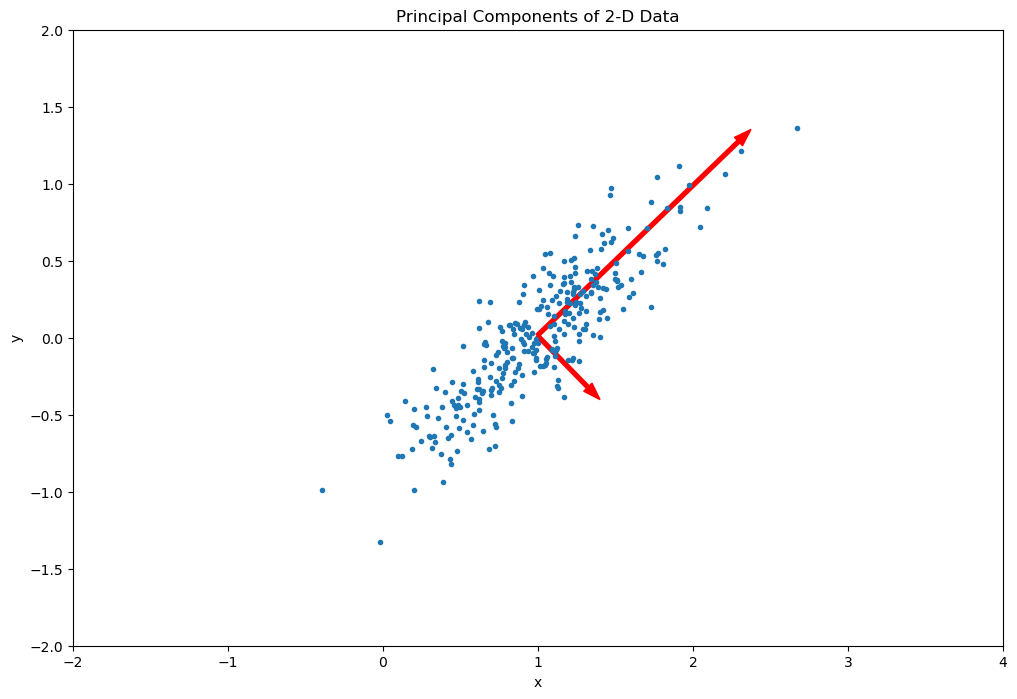

In [36]:
np.random.seed(42)
es = np.random.normal(size=[3, 300])
x = (1.5*es[0,:] + .25*es[1,:])*.3 + 1
y = es[0,:]*.4 + es[2,:]*.2

cov = np.cov([x, y])
ev, evec = np.linalg.eig(cov)

ux = np.mean(x)
uy = np.mean(y)

plt.figure(figsize=[12, 8])
plt.plot(x, y, '.')
plt.xlim(-2, 4)
plt.ylim(-2, 2);
plt.xlabel('x')
plt.ylabel('y');

plt.arrow(ux, uy, -3*np.sqrt(ev[1])*evec[0, 1], -3*np.sqrt(ev[1])*evec[1, 1], width=.025, color='r')
plt.arrow(ux, uy, 3*np.sqrt(ev[0])*evec[0, 0], 3*np.sqrt(ev[0])*evec[1, 0], width=.025, color='r');
plt.title('Principal Components of 2-D Data');

### Link to eigenvectors

The projection $\hat{\mathbf u}^T \mathbf r$ is a random scalar:

* the variance of the projection is $\text{var}[\hat{\mathbf u}^T \mathbf r] = \hat{\mathbf u}^T V \hat{\mathbf u}$.
* the first eigenvector $\mathbf v_1$ of $V$ is therefore the first principal component

If we limit ourselves to all $\mathbf u$ that are perpendicular to $\mathbf v_1$, then: 

* the second eigenvector $\mathbf v_2$ of $V$ is the principal component amongst all $\mathbf u$ with $\mathbf v_1^T \mathbf u = 0$
* this process continues for all the eigenvectors

### Variance explained

The total variance of the random vector $\tilde {\mathbf r}$ is sum of variance of all its $n$ elements, which equals:

1. trace of $V$
2. sum of all eigen values of $V$

The portion of variance explained by the first $k$ eigenvectors is 
$$
\frac{\sum_i^k \lambda_i}{\sum_i^n \lambda_i}
$$. 

## Application in interest rates

CMT rates are constant maturity treasury bond yield that are published daily by [U. S. Treasury](http://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield).


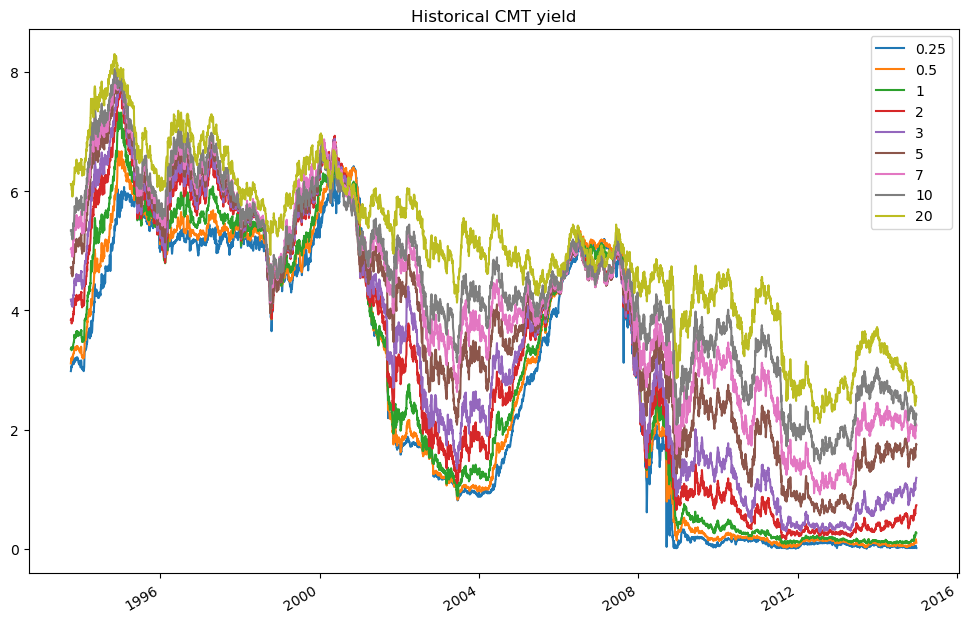

In [37]:
cmt_rates = pd.read_csv('cmt.csv', parse_dates=[0], index_col=[0])

cmt_rates.plot(legend=True, title='Historical CMT yield',figsize=(12, 8));

### Covariance matrix of interest rates

* Covariance matrix between CMT rates at different maturities

In [38]:
tenors = cmt_rates.columns.map(float)
cv = cmt_rates.cov()
display(cv)

,0.25,0.5,1,2,3,5,7,10,20
0.25,4.930772,5.022466,4.991281,4.849068,4.558414,3.927906,3.473972,2.950090,2.505140
0.5,5.022466,5.136439,5.119503,4.987844,4.695633,4.054723,3.589470,3.055570,2.597262
1,4.991281,5.119503,5.131915,5.035014,4.760224,4.136530,3.676294,3.145629,2.691677
2,4.849068,4.987844,5.035014,5.001584,4.763235,4.183509,3.744463,3.222834,2.786888
3,4.558414,4.695633,4.760224,4.763235,4.561842,4.040485,3.634975,3.143140,2.737999
5,3.927906,4.054723,4.136530,4.183509,4.040485,3.631485,3.295898,2.874698,2.535390
7,3.473972,3.589470,3.676294,3.744463,3.634975,3.295898,3.011769,2.640593,2.351153
10,2.950090,3.055570,3.145629,3.222834,3.143140,2.874698,2.640593,2.335433,2.096624
20,2.505140,2.597262,2.691677,2.786888,2.737999,2.535390,2.351153,2.096624,1.919146


### PCA components of interest rates

Let's look at the eigenvvalues and percentage explained, 

* the 1st principal component (PC) explains >95% of the variance
* the first 3 PCs are often interpreted as **level**, **slope** and **curvature**
* note that the sign of the PC is insignificant

In [39]:
xcv, vcv = np.linalg.eig(cv)
vcv = -vcv # flip the sign of eigen vectors for better illustration

pct_v = np.cumsum(xcv)/sum(xcv)*100

import pandas as pd
pd.set_option('display.precision', 3)
display(pd.DataFrame({'P/C':range(1, len(xcv)+1), 
                            'Eigenvalues':xcv, 'Cumulative Var(%)': pct_v}).set_index(['P/C']).T)

P/C,1,2,3,4,5,6,7,8,9
Eigenvalues,34.331,1.237,0.062,0.017,0.007,0.002,4.595e-04,9.641e-04,0.002
Cumulative Var(%),96.273,99.742,99.917,99.964,99.985,99.992,9.999e+01,1.000e+02,100.000


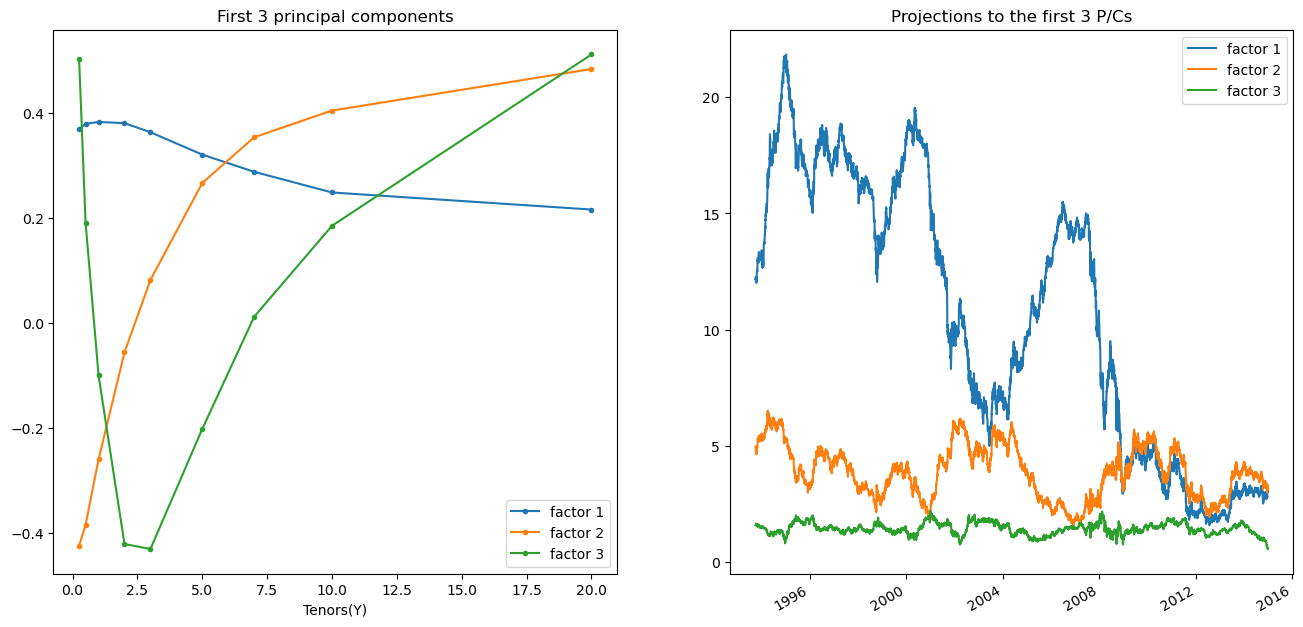

In [40]:
flab = ['factor %d' % i for i in range(1, 4)]

plt.fig = plt.figure(figsize=[16, 8])
plt.ax1 = plt.fig.add_subplot(121)
plt.plot(tenors, vcv[:, :3], '.-');
plt.xlabel('Tenors(Y)')
plt.legend(flab, loc='best')
plt.title('First 3 principal components');

fs = cmt_rates.dot(vcv).iloc[:, :3]

plt.ax2 = plt.fig.add_subplot(122)
fs.plot(ax=plt.ax2, title='Projections to the first 3 P/Cs')
plt.legend(flab, loc='best');

## Dimension reduction in Monte Carlo simulation

Given a generic $n$-dimensional SDE in vector form:

$$ d \mathbf x = \mathbf u dt + A D_\sigma d \mathbf w, \;\;\; d\mathbf w d\mathbf w^T = C dt$$

* $D_\sigma$ is a diagonal matrix of $\sigma_i$ 
* $C$ is the correlation matrix of $D_\sigma d \mathbf w$, its covariance matrix $V = D_\sigma C D_\sigma$.

Recall from Cholesky decomposition we want the form $V = LL^T$, write $D_\sigma d \mathbf w = L \mathbf z \sqrt{d t}$: 

$$
\small
\mathbb E [D_\sigma \,d \mathbf w (D_\sigma \,d \mathbf w)^T] = \mathbb E[(L\, d t \,\mathbf z \,\sqrt{d t}) (L \,d t\, \mathbf z\, \sqrt{d t})^T ] 
= L \mathbb E[d t \,\mathbf z \,d t \,\mathbf z^T] L^T d t = V d t
$$

* where $\mathbf z$ is independent standard normal random vector.
* we can reduce the dimensionality of $\mathbf z$ by finding a rectangular $\dot L$ so that $V \approx \dot L {\dot L}^T$

### Dimension reduction using PCA

Use the PCA of the covariance matrix: 
$$
V = R_V \Lambda_V R_V^T \approx \dot R_V \dot \Lambda_V \dot R_V^T = \dot R_V \dot H_V \dot H_V^T  \dot R_V^T = (\overbrace{\dot R_V \dot H_V}^{L_V})(\dot R_V\dot H_V )^T \\
$$

Or PCA on the correlation matrix:
$$
V = D_\sigma C D_\sigma = D_\sigma (R_C \Lambda_C R_C^T) D_\sigma \approx D_\sigma \dot R_C \dot \Lambda_C \dot R_C^T D_\sigma = D_\sigma \dot R_C \dot H_C \dot H_C^T  \dot R_C^T D_\sigma^T = (\overbrace{D_\sigma \dot R_C \dot H_C}^{L_C})(D_\sigma \dot R_C\dot H_C )^T 
$$

* $\Lambda = H H^T$, both $\Lambda$ and $H$ are diagonal matrices with positive elements
* The dotted version only retains the first $k$ eigenvalues
* $\dot R$ and $L_V, L_C$ are $n \times k$ matrices; $\dot \Lambda$ are $k \times k$ matrices.

Simulation can then be driven by $D_\sigma \delta \mathbf w = L \dot{\mathbf z} \sqrt{\delta t}$:
* Either $L_V = \dot R_V \dot H_V$ or $L_C = D_\sigma \dot R_C \dot H_C$ works
* $\dot{\mathbf z}$ is of length $k$ only

**Key Idea**: To use PCA for dimension reduction, calculate the principal components, place them in descending order of size, and then select a "cutoff". Generally, choose the first $n$ principal components that represent X% (like 95%) of the variance of the data. Then use the $n$ corresponding eigenvectors to represent the data.

## PCA is scale variant

Given the eigenvalue decompositions of the covariance and correlation matrices:

$$R_V \Lambda_V R_V^T = V = D_\sigma C D_\sigma = D_\sigma R_C \Lambda_C R_C^T D_\sigma$$

Are they equivalent? 

* $D_\sigma R_C \Lambda_C R_C^T D_\sigma = (D_\sigma R_C) \Lambda_C (D_\sigma R_C)^T$
  * implies $\Lambda_C = \Lambda_V$ and $R_V = D_\sigma R_C$

* $D_\sigma R_C \Lambda_C R_C^T D_\sigma = R_C (D_\sigma \Lambda_C D_\sigma) R_C^T$
  * implies $ \Lambda_V = D_\sigma \Lambda_C D_\sigma $ and $R_C = R_V$

However, neither is true because: 
* $D_\sigma R_C$ is not orthogonal: $(D_\sigma R_C)(D_\sigma R_C)^T = D_\sigma R_C R_C^T D_\sigma = D_\sigma D_\sigma \ne I$
* $V = D_\sigma C D_\sigma$, $V$ and $C$ are not similar
* $D_\sigma R_C \ne R_C D_\sigma$, even when $D_\sigma$ is diagonal.

There is no simple relationship between these two eigenvalue decompositions.
* despite $C$ and $V$ are covariance matrix of $\mathbf r$ and $D_\sigma^{-1} \mathbf r$ respectively

### Orthogonality depends on scale

The PCs are no longer orthogonal after stretching horizontally.

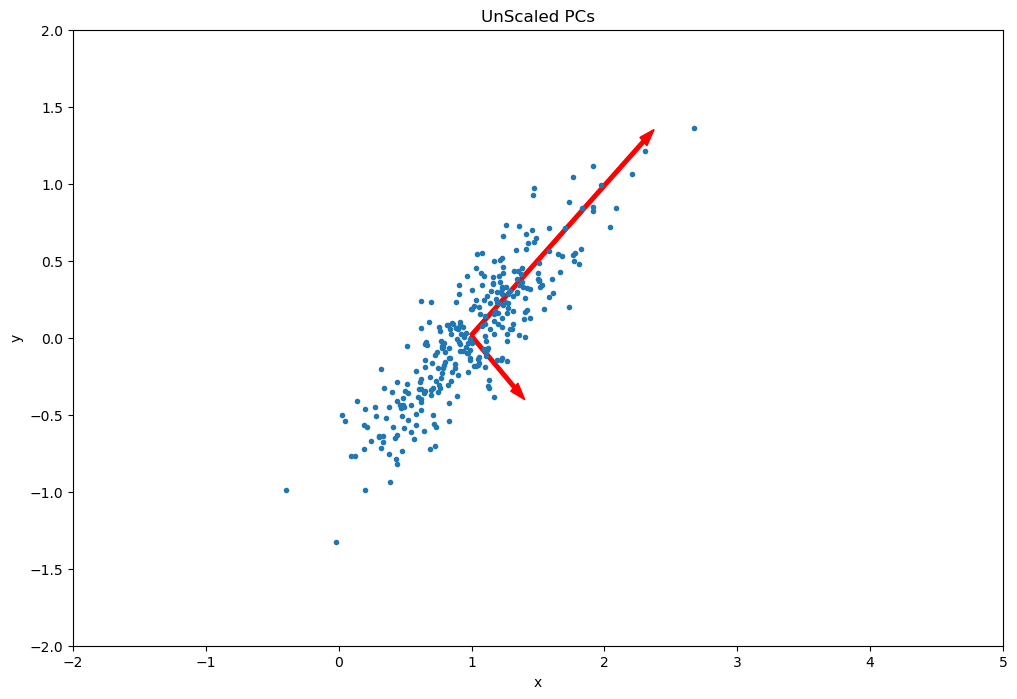

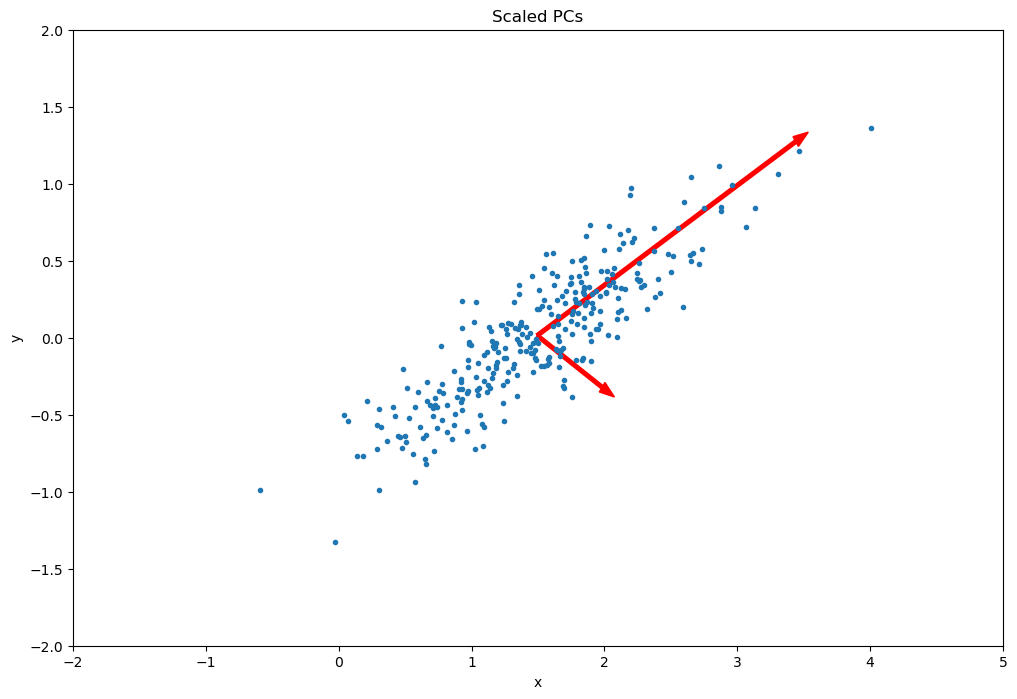

In [41]:
plt.figure(figsize=[12, 8])
#plt.subplot(1, 2, 1)

plt.plot(x, y, '.')
plt.xlim(-2, 5)
plt.ylim(-2, 2);
plt.xlabel('x')
plt.ylabel('y');

plt.arrow(ux, uy, -3*np.sqrt(ev[1])*evec[0, 1], -3*np.sqrt(ev[1])*evec[1, 1], width=.025, color='r')
plt.arrow(ux, uy, 3*np.sqrt(ev[0])*evec[0, 0], 3*np.sqrt(ev[0])*evec[1, 0], width=.025, color='r');
plt.title('UnScaled PCs');

#plt.subplot(1, 2, 2)
plt.figure(figsize=[12, 8])
scale = 1.5
plt.plot(x*scale, y, '.')
plt.xlim(-2, 5)
plt.ylim(-2, 2);
plt.xlabel('x')
plt.ylabel('y');

plt.arrow(ux*scale, uy, -3*np.sqrt(ev[1])*evec[0, 1]*scale, -3*np.sqrt(ev[1])*evec[1, 1], width=.025, color='r')
plt.arrow(ux*scale, uy, 3*np.sqrt(ev[0])*evec[0, 0]*scale, 3*np.sqrt(ev[0])*evec[1, 0], width=.025, color='r');
plt.title('Scaled PCs');

## Before applying PCA 

PCA is a powerful technique, however, beware of its limitations:

* PCA factors are not real market risk factors
 * It does not lead to tradable hedging strategies
* PCA is not scale (or unit) invariant
 * it requires all the dimensions to have the same natural unit
 * mixing factors of different magnitude can lead to trouble: eg, mixing interest rates with equities
 * PCA results are different when applied to co-variance matrix and correlation matrix
 
PCA is usually applied to different data points of the same type

* different tenors/strikes of interest rates, volatility etc.
* price movements of the same sector/asset class

PCA is not necessarily consistent over time: if you decompose returns on assets for one time period and then decompose the returns on the same set of assets for a different time period, the principal components are not necessarily the same. They could switch order, or they could be entirely different!

How [might](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) you resolve this issue?

## PCA vs. least square

The PCA analysis has some similarity to the least square problem, both of them can be viewed as minimizing the L2 norm of residual errors. 

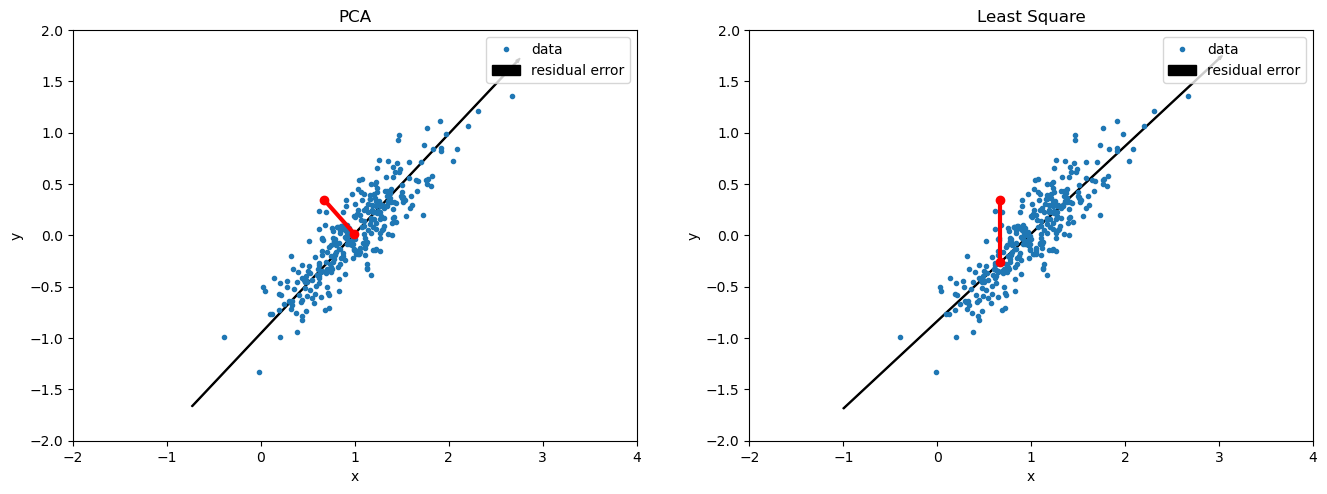

In [42]:
xs = np.array([x, np.ones(len(x))]).T
beta = np.linalg.inv(xs.T.dot(xs)).dot(xs.T).dot(y)

s_x, s_y = sp.symbols('x, y')
br = np.round(beta, 4)

plt.figure(figsize=[16, 5.333])
plt.subplot(1, 2, 1)
plt.plot(x, y, '.')
plt.xlim(-2, 4)
plt.ylim(-2, 2);
plt.xlabel('x')
plt.ylabel('y');

dx = 4*np.sqrt(ev[0])*evec[0, 0]
dy = 4*np.sqrt(ev[0])*evec[1, 0]

plt.arrow(ux-dx, uy-dy, 2*dx, 2*dy, width=.01, color='k');

ex = 3*np.sqrt(ev[1])*evec[0, 1]
ey = 3*np.sqrt(ev[1])*evec[1, 1]
plt.plot([ux, ux+ex], [uy, uy+ey], 'r-o', lw=3)
plt.legend(['data', 'residual error'], loc='best')

plt.title('PCA');

plt.subplot(1, 2, 2)
plt.plot(x, y, '.')
plt.xlim(-2, 4)
plt.ylim(-2, 2);
plt.xlabel('x')
plt.ylabel('y');
plt.arrow(-1, -1*beta[0]+beta[1], 4, 4*beta[0], width=.01, color='k');
y0 = (ux+ex)*beta[0] + beta[1]
plt.plot([ux+ex, ux+ex], [y0, uy+ey], 'r-o', lw=3)
plt.legend(['data', 'residual error'], loc='best')
plt.title('Least Square');

## PCA or regression?

The main differences between PCA and least square (regression):

|  | PCA | Least Square/Regression |
| :-----: | :----: | :----: |
| Scale Invariant | No | Yes |
| Symmetry in Dimension | Yes | No |

To choose between the two:
* Use least square/regression when there are clear explanatory variables and causality
* Use PCA when there is a set of related variables but no clear causality
* PCA requires a natural unit for all dimensions

## To what variables should we apply PCA?

It is important to choose the right variable to apply PCA. The main considerations are:

* Values or changes
 * Equity prices or returns?
 * IR levels or changes?
 * Key consideration: stationarity and mean reversion, horizon of your model prediction
 
* Spot or forward
 * Forward is usually a better choice than spot
 
Since the PCA is commonly applied to a correlation/covariance matrix, it is equivalent to ask what variables' correlation/covariance matrix we should model.

## Spurious correlation

Spurious correlation: variables can appear to be significantly correlated, but it is just an illusion.

### Example: equity price

In [43]:
f3 = pd.read_csv('f3.csv', parse_dates=[0]).set_index('Date').sort_index()
r = np.log(f3).diff()
display(Markdown('**Price Correlation:**'))
display(f3.corr())
print( )
display(Markdown('**Return Correlation:**'))
display(r.corr())

**Price Correlation:**

,SPY,GLD,OIL
SPY,1.000,0.178,0.011
GLD,0.178,1.000,-0.524
OIL,0.011,-0.524,1.000


**Return Correlation:**

,SPY,GLD,OIL
SPY,1.000,0.032,0.419
GLD,0.032,1.000,0.301
OIL,0.419,0.301,1.000


### Example: spot rates

Consider the correlation between 9Y and 10Y spot rates and forward rates:

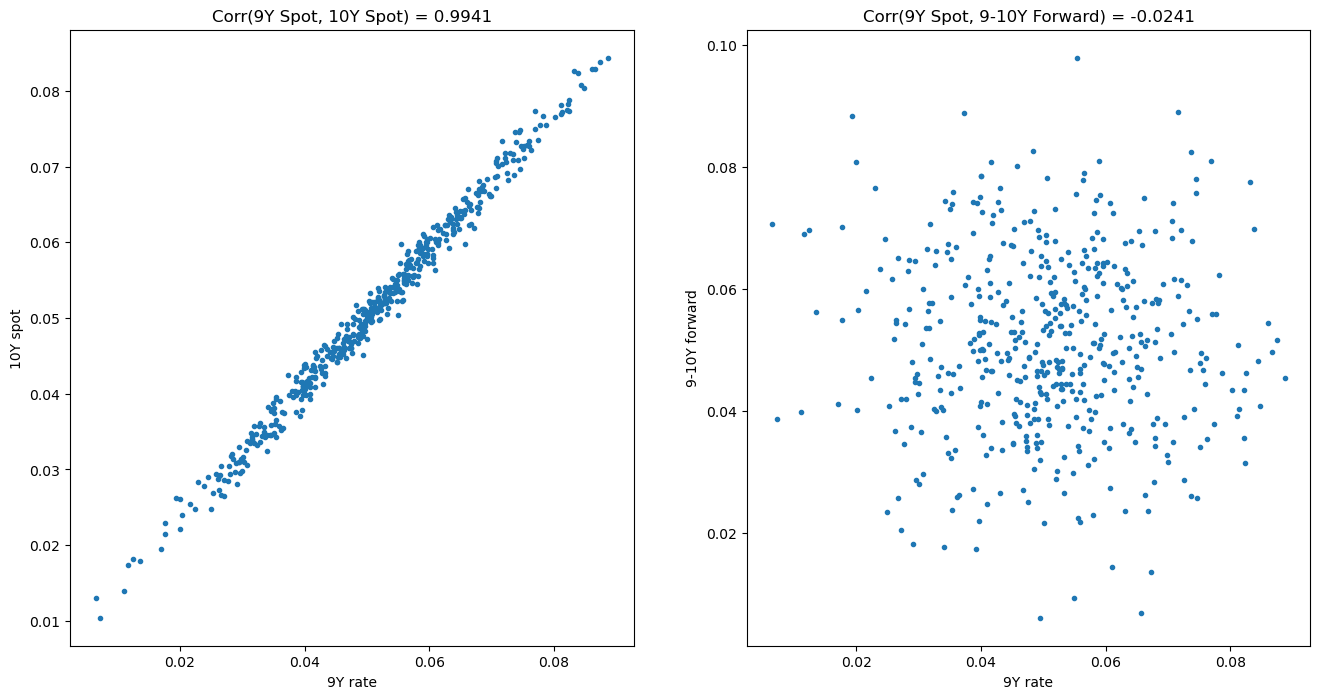

In [44]:
es = np.random.normal(size=[2, 500])
r0 = es[0,:]*.015 + .05
f1 = es[1,:]*.015 + .05

r1 = -np.log(np.exp(-9*r0-f1))/10


rc = np.corrcoef(np.array([r0, r1]))[0, 1]
fc = np.corrcoef(np.array([r0, f1]))[0, 1]

plt.figure(figsize=[16, 8])
plt.subplot(1, 2, 1)
plt.plot(r0, r1, '.')
plt.xlabel('9Y rate')
plt.ylabel('10Y spot')
plt.title('Corr(9Y Spot, 10Y Spot) = %.4f'% rc)

plt.subplot(1, 2, 2)
plt.plot(r0, f1, '.')
plt.xlabel('9Y rate')
plt.ylabel('9-10Y forward')
plt.title('Corr(9Y Spot, 9-10Y Forward) = %.4f'% fc);

$$
\exp(-10 r_{10}) = \exp(-9 r_9)\exp(-(10-9) f(9, 10) )
$$

$$
r_{10} = 0.9r_9 + 0.1f(9, 10) 
$$

* the $f(9, 10)$ is the 9Y to 10Y forward rate (*i.e.* the one-year forward rate 9 years from now).
* and, of course, $r_{10} = f(0, 10)$

#### Correlated by construction

$$ r_{10} = 0.9r_9 + 0.1f(9, 10) $$

* The high correlation between spot rates to similar tenors are by construction
* PCA analysis can be misleading in percentage of variance explained
  * the variance of spot rates of short tenors are counted multiple times
* May not be a problem if we have unlimited precision, but we usually only keep the first few eigen vectors in PCA
* it's usually better to model the correlation/covariance matrix of forward rates

# Singular Value Decomposition (SVD)


## Definition

For any real matrix $M$, $\sigma_i \geq 0$ is a singular value if there exists two unit-length vectors $\mathbf {u_i, v_i}$ such that:

1. $M \mathbf v_i = \sigma \,\mathbf u_i$ 
2. $\mathbf u_i^T M = \sigma \,\mathbf v_i^T$

$\mathbf {u_i, v_i}$ are called left and right singular vectors of $M$.
* unlike eigenvalues, singular values are **always** non-negative.

By convention, 
* we represent singular vectors as unit L-2 vectors, i.e., $\mathbf u_i^T\mathbf u_i = \mathbf v_i^T \mathbf v_i = 1$,
* we name the singular values in descending order as $\sigma_1, \sigma_2, ..., \sigma_n$, and refer corresponding singular vector pairs as $ (\mathbf u_1, \mathbf v_1), (\mathbf u_2, \mathbf v_2), ..., (\mathbf u_n, \mathbf v_n) $.

## Singular vectors and maximization

Consider $\mathbf u_i^T M \mathbf v_i$ for real matrix $M$:

* $\mathbf {u_1, v_1}$ maximize $\mathbf u_i^T M \mathbf v_i$ amongst all unit $\mathbf {u_i, v_i}$ vectors. 

Apply the Lagrange multiplier, with constraints $\mathbf u_i^T  \mathbf u_i = \mathbf v_i^T  \mathbf v_i = 1$:

$$ 
\begin{array}{cc}
\\\mathcal L = \mathbf u_i^T M \mathbf v_i - \gamma_1 (\mathbf u_i^T  \mathbf u_i - 1) - \gamma_2 (\mathbf v_i^T  \mathbf v_i - 1) \\
\\
\frac{\partial \mathcal L}{\partial{\mathbf u_i^T}} = M \mathbf v_i - 2 \gamma_1 \mathbf u_i = \mathbf 0 \iff \mathbf u_i^T M \mathbf v_i - 2 \gamma_1 = \mathbf 0\\
\\
\frac{\partial \mathcal L}{\partial{\mathbf v_i}} = \mathbf u_i^T M  - 2\gamma_2 \mathbf v_i^T = \mathbf 0^T \iff \mathbf u_i^T M \mathbf v_i- 2\gamma_2 = \mathbf 0
\end{array}
$$

Therefore,
$$ 2\gamma_1 = \small \mathbf u_1^T M \mathbf v_1  = 2\gamma_2 $$
$$M \mathbf v_1 = \sigma \mathbf u_1 \;,\; M^T\mathbf u_1 = \sigma \mathbf v_1 $$

## Orthogonality of Singular Vectors

Given $\mathbf{u_1, v_1}$ are the first singular vectors of $M$:

$$\mathbf x^T \mathbf v_1 = 0  \iff (M \mathbf x)^T \mathbf u_1 = 0 \iff \mathbf u_1^T M \mathbf x  = 0 $$

because:

$$ (M \mathbf x)^T \mathbf u_1 = \mathbf x^T M^T \mathbf u_1 = \mathbf x^T \sigma_1 \mathbf v_1  = 0 $$

Therefore, if we only consider those $\mathbf u_i^T M^T \mathbf u_1 = 0$ ($M$-orthogonal), the corresponding $\mathbf v_i$ must be orthogonal to $\mathbf v_1$ :

* $\mathbf {u_2, v_2}$ maximizes $\mathbf u^T M \mathbf v$  among those $(\mathbf u_i, \mathbf v_i)$ orthogonal to $\mathbf u_1, \mathbf v_1$
* this process can repeat for all singular vectors (assuming singular values are distinct)

## Singular value decomposition

We can write all singular vectors and singular values in matrix format, which is the singular value decomposition (SVD):

$$
U^T M V = D_\sigma \iff M = U D_\sigma V^T
$$

| | $M$ | $U$ | $D_\sigma$ | $V$ |
| :---: | :---: | :----: | :----: | :---: |
| Name | Original Matrix | Left singular vector | Singular value | Right singular vector |
| Type |  Real | Orthogonal, real | Diagonal, positive | Orthogonal, real |
| Size | $m \times n$ | $m\times m$ | $m\times n$ | $n \times n$ |

* For matrix $M$, there can only be $\min(m, n) = r$ singular values at most, where $r$ is the rank of the matrix
* The left/right singular vectors form a basis for the vector space of $\mathbf {u}$ and $\mathbf v$ respectively

## Graphical representation of SVD

Illustration from [Wikipedia](https://en.wikipedia.org/wiki/Singular_value_decomposition), in our notation $\sum = D_\sigma$ and $V^* = V^H$:

<center> <img src="svd.png" width=500 height=500></center>

## Link between SVD and EVD


$$
M = U D_\sigma V^T
$$

SVD and eigenvalue decomposition (EVD) are closely related to each other:

SVD essentially reduces to a form of EVD if $M$ is symmetric positive definite
* $MM^T = U D_\sigma V^T V D_\sigma^T U^T = U D_\sigma D_\sigma^T U^T$:
  * the column vectors of $U$ are the eigenvectors of $MM^T$

* $M^TM = VD_\sigma^TU^TUD_\sigma V^T = V D_\sigma D_\sigma^T V^T$: 
  * the column vectors of $V$ are the eigenvectors of $M^TM$

The singular values are the positive square roots of eigenvalues of $MM^T$ or $M^TM$

## SVD of pseudo inverse

Given the SVD decomposition $X = UD_\sigma V^T$, the SVD of $X$'s pseudo inverse is:

$$X^+ = (X^TX)^{-1}X^T = V D_\sigma^+ U^T$$

where $D_\sigma^+$ is the pseudo inverse of $D_\sigma$, whose diagonal elements are the reciprocals of those in $D_\sigma$.

Proof: the last equation is obviously true, and every step is reversible:

$$
\begin{array}{cc}
\begin{aligned}
&(X^TX)^{-1}X^T = VD_\sigma^+ U^T \\[2pt]
&(V D_\sigma^T D_\sigma V^T)^{-1} VD_\sigma^TU^T = VD_\sigma^+ U^T \\[2pt]
&(V D_\sigma^T D_\sigma V^T)^{-1} VD_\sigma^TD_\sigma = V D_\sigma^+D_\sigma \\[2pt]
&(V D_\sigma^T D_\sigma V^T)^{-1} VD_\sigma^TD_\sigma = V \\[2pt]
&(V D_\sigma^T D_\sigma V^T)^{-1} (VD_\sigma^TD_\sigma V^T) = I 
\end{aligned}
\end{array}
$$

SVD is another way to solve the least square problem.

## L2 norm and condition number

Consider a real matrix $A$, its L2 norm is defined as the maximum of $\frac{\Vert A \mathbf x \Vert_2}{\Vert \mathbf x \Vert_2}$:

$$
\Vert A \Vert_2^2 = \max_{\mathbf x} \frac{\Vert A \mathbf x \Vert_2^2}{\Vert \mathbf x \Vert_2^2} 
= \max_{\mathbf x} \frac{\mathbf x^T A^T A \mathbf x}{\mathbf x^T \mathbf x} 
= \max_{\hat{\mathbf x}} \hat{\mathbf x}^T A^T A \hat{\mathbf x} = \sigma_1(A)^2$$

where $\hat{\mathbf x} = \frac{\mathbf x}{\Vert \mathbf x \Vert_2}$ is a unit vector, and $\sigma_1(A)$ is the largest singular value of $A$.

For a generic non-square matrix $A$:
* the L-2 norm of a matrix is its largest singular value: $\Vert A \Vert_2 = \sigma_1(A)$
* the L-2 norm of the pseudo inverse $A^+$: $\Vert A^+ \Vert_2 = \frac{1}{\sigma_n(A)}$
  * $\sigma_n(A)$ is the smallest singular value of $A$.
* the L-2 condition number of a matrix $A$ is therefore: $k(A) = \Vert A \Vert_2 \Vert A^+ \Vert_2 = \frac{\sigma_1(A)}{\sigma_n(A)}$

## SVD and condition number

SVD offers clear intuition in understanding the L-2 condition number of a Matrix $A$.

For a linear system $\mathbf y = A \mathbf x$, consider a perturbation $\delta \mathbf x$ to the input $\mathbf x$:

* if $\delta \mathbf x$ is stretched by a larger factor than $\mathbf x$, then the relative error grows.
* the worst case occurs when $\mathbf x$ is stretched by $\sigma_n(A)$, while $\delta \mathbf x$ is stretched by $\sigma_1(A)$
  * the relative error grows by a factor of $\frac{\sigma_1(A)}{\sigma_n(A)}$.
* Orthogonal matrix represents a pure rotation
  * all singular values are 1, no stretches, thus the relative error does not grow

## Spot the trouble

When working with near singular matrix,  SVD can identify ill-conditioned area:

* real world covariance and correlation matrix are often near singular
* numerical instability arises when inputs are very close to signular vectors with small singular values 
  * *e.g.*, when return forecast is in the same direction as the last singular vector ...

## Rank deficiency and reduction

Singular matrix are those that are not fully ranked
* Square matrix: non-invertible, its determinant is 0
* In practice, matrices are rarely exactly singular due to numerical errors

SVD can detect near singular matrices
* near singular matrix has very small singular values

SVD can find low rank approximations to a full rank matrix
* by zeroing out small singular values

## Condition number for EVD

What is the change in $\lambda_i$ if we perturb the symmetric matrix $A$? 

$$ A \mathbf v_i = \lambda_i \mathbf v_i$$

Apply the perturbation analysis: $\delta A = \dot{A} \epsilon,\, \delta \lambda_i = \dot{\lambda_i} \epsilon,\, 
\delta \mathbf v_i = \dot{\mathbf v_i} \epsilon$, the first order terms of $\epsilon$:


\begin{align*} 
(A + \dot{A}\epsilon )(\mathbf v_i + \dot{\mathbf v_i}\epsilon) &= (\lambda_i + \dot{\lambda_i}\epsilon) (\mathbf v_i + \dot{\mathbf v_i} \epsilon)\dot{A}\mathbf v_i + A \dot{\mathbf v_i} \\
&= \lambda_i \dot{\mathbf v_i} + \dot{\lambda_i}\mathbf v_i \mathbf v_i^T\dot{A}\mathbf v_i + \mathbf v_i^T A \dot{\mathbf v_i} \\
&= \mathbf v_i^T \lambda_i \dot{\mathbf v_i} + \mathbf v_i^T \dot{\lambda_i}\mathbf v_i \mathbf v_i^T\dot{A}\mathbf v_i \\
&= \dot{\lambda_i}
\end{align*}


Therefore:
$$
\\ \frac{ | \delta \lambda_i |}{| \lambda_i |} = \frac{\Vert \mathbf v_i^T\delta A \mathbf v_i\Vert_2}{|\lambda_i|}
\le \frac{\Vert \delta A \Vert_2}{|\lambda_i|} = \frac{\Vert A\Vert_2}{|\lambda_i|} \frac{\Vert \delta A \Vert_2}{\Vert A \Vert_2}
 = \left\vert \frac{\lambda_1}{\lambda_i}\right\vert \frac{\Vert \delta A \Vert_2}{\Vert A \Vert_2} 
$$
 
* The eigenvalue's conditional number for a symmetric matrix $A$ is therefore determined by how much larger the largest eigenvalue is: $k(A) = \left\vert \frac{\lambda_1}{\lambda_i} \right\vert$.
* The smaller eigenvalues are less accurate; we should ignore them.

## Decomposition summary
 
For real matrix $A$:
 
| Decomposition | Applicability | Formula | Results | Key applications |
| :---: | :---: | :---: | :---: |  :---: | 
| LU | square, full rank |  $$A = LU$$ | lower, upper triangular | matrix inversion |
| Cholesky | symmetric positive definite | $A = LL^T$ | lower triangular | simulate correlated factors |
| QR | any | $A = Q R$ | orthogonal, upper triangular | solve eigenvalues, least square|
| EVD | symmetric | $A = R\Lambda R^T$ | orthogonal, real diagonal | PCA |
| SVD | any | $A = U\Sigma V^T$ | orthogonal, positive diagonal, orthogonal | error analysis, rank reduction |


# Column-Row multiplication of matrices

Recall, for any matrix: **Row Rank = Column Rank**, or **r independent columns $\iff$ r independent rows**. 

We also know that a nonzero matrix $uv^T$ has one independent column and one independent row. All columns are multiples of $\mathbf u$ and all rows are multiples of $\mathbf v^T$. The matrix is rank 1.

Looking at the product $AB$, using the columns of $A$ times the rows of $B$. Let $\mathbf a_1, \mathbf a_2,\dots,\mathbf a_n$ be the $n$ columns of $A$. The $B$ must have $n$ rows $\mathbf b_1^*,\mathbf b_2^*,\dots,\mathbf b_n^*$. **The product $AB$ is the sum of columns $\mathbf a_k$ times rows $\mathbf b_k^*$**.


$$
A B = 
\begin{pmatrix}
 \vert &  & \vert \\  
 \mathbf a_1 & \cdots & \mathbf a_n \\ 
 \vert &   & \vert  
\end{pmatrix}
\begin{pmatrix}
 -- & \mathbf b_1^* & -- \\  
  & \vdots &  \\ 
 -- & \mathbf b_n^*  & --
 \end{pmatrix}
 =
 \mathbf a_1 \mathbf b_1^* + \mathbf a_2 \mathbf b_2^*+ \cdots + \mathbf a_n \mathbf b_n^*
$$

$$
\begin{pmatrix}
1 & 0 \\
3 & 1 
\end{pmatrix}
\begin{pmatrix}
2 & 4\\
0 & 5
\end{pmatrix}
=
\begin{pmatrix}
1\\
3
\end{pmatrix}
\begin{pmatrix}
2 & 4
\end{pmatrix}
+
\begin{pmatrix}
0\\
1
\end{pmatrix}
\begin{pmatrix}
0 & 5
\end{pmatrix}
=
\begin{pmatrix}
2 & 4 \\
6 & 12 
\end{pmatrix}
+
\begin{pmatrix}
0 & 0\\
0 & 5
\end{pmatrix}
=
\begin{pmatrix}
2 & 4 \\
6 & 17 
\end{pmatrix}
$$

### Insight from Column ties Row

In general, we are looking for the *most important part of matrix* $A$. That is not necessarily the biggest number. What we want is the largest pieces of $A$. Those pieces are **rank one matrices** $\mathbf u \mathbf v^T$. What we want to do is factor $A$ into $CR$ and look at the pieces $\mathbf c_k \mathbf r_k^*$ of $A = CR$.

Factoring $A$ into $CR$ is the reverse of multipluing $CR=A$.

### 5 most important factorizations


1. $A=LU$ comes from **elimination**. The matrix $L$ is lower triangular and the matrix $U$ is upper triangular.

2. $A=QR$ comes from **orthogonalizing** the columns $a_1$ to $a_n$ as in Gram-Schmidt. $Q$ has orthonormal columns ($Q^TQ$) and $R$ is upper triangular.

3. $S=Q \Lambda Q$ comes from the **eigenvalues** $\lambda_1,\dots,\lambda_n$ of a symmetric matrix $S=S^T$. Eigenvalues on the diagonal of $\Lambda$. **Orthonormal eigenvectors** in the columns of $Q$.

4. $A=X \Lambda X^{-1}$ is **diagonalization** when $A$ is $n \times n$ wiht $n$ independent eigenvectors. *Eigenvalues* of $A$ on the diagonal of $\Lambda$. *Eigenvectors* of $A$ in the columns of $X$.

5. $A=U \Sigma V^T$ is the **Singular Value Decomposition** of any matrix $A$ (square or not). **Singular values** $\sigma_1,\dots,\sigma_r$ in $\Sigma$. Orthonormal **singular vectors** in $U$ and $V$.

Consider 3 above, the rank one pieces are:
$$ 
S = (Q \Lambda)Q^T = (\mathbf \lambda_1 \mathbf q_1) \mathbf q_1^T + (\mathbf \lambda_1 \mathbf q_2) \mathbf q_2^T + \cdots + (\mathbf \lambda_1 \mathbf q_n) \mathbf q_n^T 
$$

And all are symmetric since $\mathbf q_i \mathbf q_i^T$ is $\mathbf q_i^T \mathbf q_i$

Note that the columns of $Q \Lambda$ are $\mathbf \lambda_1 \mathbf q_1$ to $\mathbf \lambda_n \mathbf q_n$. When you multiple a martix on the  right by the diagonal matrix $\Lambda$, you multiply its columns by the $\mathbf \lambda$'s.

**So, dimension reduction using EVD is simply choosing which of the rank one pieces to drop. (Same idea for SVD.)**

### Back to Householder Reflections

To form the reflection matrix $H_n$, we start with the identity matrix and choose a unit vector $\mathbf u$ We subtract a rank one matrix $2 \mathbf u \mathbf u^t$, where we choose $\mathbf u = (1, 1, \dots, 1)/ \sqrt{n}$. This gives us the Householder matrix $H_n = I - 2 \mathbf u \mathbf u^T$.